In [1]:
import sys
sys.path.insert(0,'../..')

In [2]:
from numerical_integrators.singlestep import rk4
from numerical_integrators.adaptive_step import rkdp54

In [3]:
import multiprocessing as mp

In [4]:
import matplotlib as mpl
mpl.use("pgf")

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

In [21]:
import numpy as np
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [6]:
from numba import njit

In [7]:
xmin,xmax = 0,2*np.pi
ymin,ymax = 0,2*np.pi
zmin,zmax = 0,2*np.pi

nx = 100
ny = 100
nz = 100

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [49]:
@njit
def func(t,x,A=1,B=1,C=1):
    ret = np.empty(x.shape)
    ret[0]  = A*np.sin(x[2])+C*np.cos(x[1])
    ret[1]  = B*np.sin(x[0])+A*np.cos(x[2])
    ret[2]  = C*np.sin(x[1])+B*np.cos(x[0])
    ret[3]  = -C*np.sin(x[1])*x[6] + A*np.cos(x[2])*x[9]
    ret[4]  = -C*np.sin(x[1])*x[7] + A*np.cos(x[2])*x[10]
    ret[5]  = -C*np.sin(x[1])*x[8] + A*np.cos(x[2])*x[11]
    ret[6]  = B*np.cos(x[0])*x[3] + -A*np.sin(x[2])*x[9]
    ret[7]  = B*np.cos(x[0])*x[4] + -A*np.sin(x[2])*x[10]
    ret[8]  = B*np.cos(x[0])*x[5] + -A*np.sin(x[2])*x[11]
    ret[9]  = -B*np.sin(x[0])*x[3] + C*np.cos(x[1])*x[6]
    ret[10] = -B*np.sin(x[0])*x[4] + C*np.cos(x[1])*x[7]
    ret[11] = -B*np.sin(x[0])*x[5] + C*np.cos(x[1])*x[8]
    return ret

In [50]:
def find_final_state(t0,tf,x,y,z,h,fun,integ,nproc=4,atol=None,rtol=None):
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))
    grid[3] = 1
    grid[7] = 1
    grid[11] = 1
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int)
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=advect_part, args=(t0,tf,grid[:,div[j]:div[j+1]],h,fun,integ,qs[j],atol,rtol)) for j in range(nproc)]
    for p in ps:
        p.start()
    for j,q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    [p.join() for p in ps]
    
    return grid[:3].transpose(1,2,3,0), grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

In [51]:
def advect_part(t0,tf,pos,h,fun,integ,q,atol=None,rtol=None):
    #t = np.ones((pos.shape[1:]))*t0
    #h = np.ones((pos.shape[1:]))*h
    #while np.any(np.less(t,tf)):
    #    h = np.minimum(h,tf-t)
    #    t,pos,h = integ(t,pos,h,fun,atol,rtol)
    t = t0
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        t,pos,h = integ(t,pos,h,fun)
    q.put(pos)

In [52]:
t0 = 0
tf = 1
h = 0.1
integ = rk4
#integ = rk4

fm, jac = find_final_state(t0,tf,x,y,z,h,func,integ,atol=1e-4,rtol=1e-4)

In [41]:
def get_evals_and_evecs(jac):
    u,s,v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (lm1, lm2, lm3), (xi1, xi2, xi3)

In [42]:
(lm1,lm2,lm3), (xi1,xi2,xi3) = get_evals_and_evecs(jac)

In [43]:
lm1.shape

(100, 100, 100)

In [19]:
s = np.linalg.svd(jac,compute_uv=False)

In [20]:
s.shape

(100, 100, 100, 3)

<IPython.core.display.Javascript object>


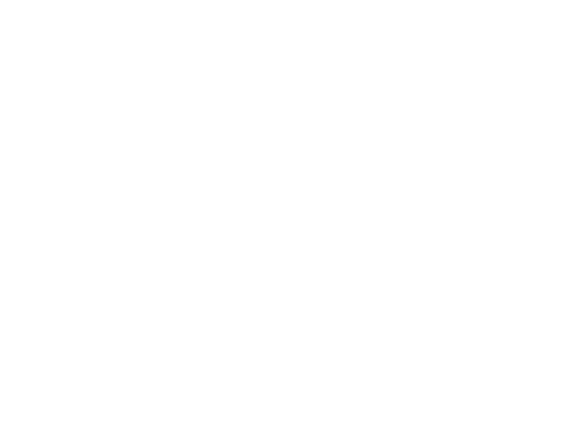

In [24]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.pcolormesh(x,y,np.log(s[...,0,0]**2))

<IPython.core.display.Javascript object>


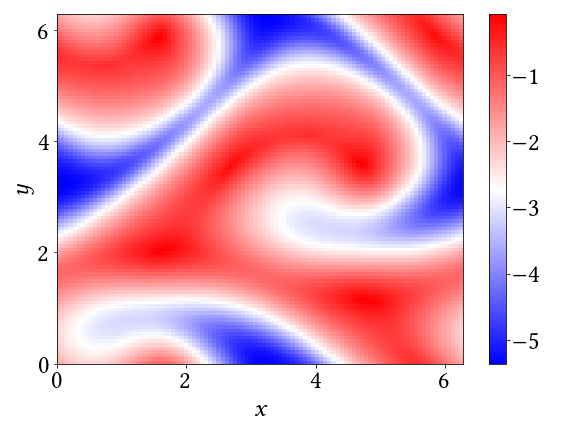

In [48]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
msh=ax.pcolormesh(x,y,np.log(lm1[...,0]),cmap='bwr')
bar=plt.colorbar(msh)
ax.set_xlabel(r'$x$',fontsize=25)
ax.set_ylabel(r'$y$',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=10)
bar.ax.tick_params(labelsize=25)
plt.tight_layout()
#plt.savefig('/home/arne/Desktop/test.png')

In [47]:
np.mean(lm1*lm2*lm3)

0.9999999629322331